In [1]:
import anndata as ad
import pandas as pd
import magic

In [2]:
adata = ad.read_h5ad("To_create_plot_gene_trend.h5ad")

In [3]:
emt_data = adata.to_df()
emt_data['umap_ddhodge_potential'] = adata.obs['umap_ddhodge_potential']

dense_matrix = adata.layers['X_spliced'].todense()
# Convert the dense matrix to a DataFrame
df = pd.DataFrame(dense_matrix)

df.index = adata.obs_names 
df.columns = adata.var_names 

In [4]:
import magic
import scprep

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
magic_op = magic.MAGIC()

### Gene expression data
emt_data = adata.to_df()
emt_data['umap_ddhodge_potential'] = adata.obs['umap_ddhodge_potential']
emt_data = scprep.normalize.library_size_normalize(emt_data)


### Splicing data.
emt_data2 = df
emt_data2['umap_ddhodge_potential'] = adata.obs['umap_ddhodge_potential']
emt_data2 = scprep.normalize.library_size_normalize(emt_data2)

Calculating MAGIC...
  Running MAGIC on 2044 cells and 4708 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/home/yang/.local/lib/python3.11/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 1.02 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.51 seconds.
    Calculating affinities...
    Calculated affinities in 0.45 seconds.
  Calculated graph and diffusion operator in 2.02 seconds.
  Calculating imputation...
Calculated MAGIC in 2.06 seconds.
Calculating MAGIC...
  Running MAGIC on 2044 cells and 4708 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.96 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.49 seconds.
    Calculating affinities...
    Calculated affinities in 0.43 seconds.
  Calculated graph and diffusion operator in 1.91 seconds.
  Calculating imputation...
Calculated MAGIC in 1.96 seconds.


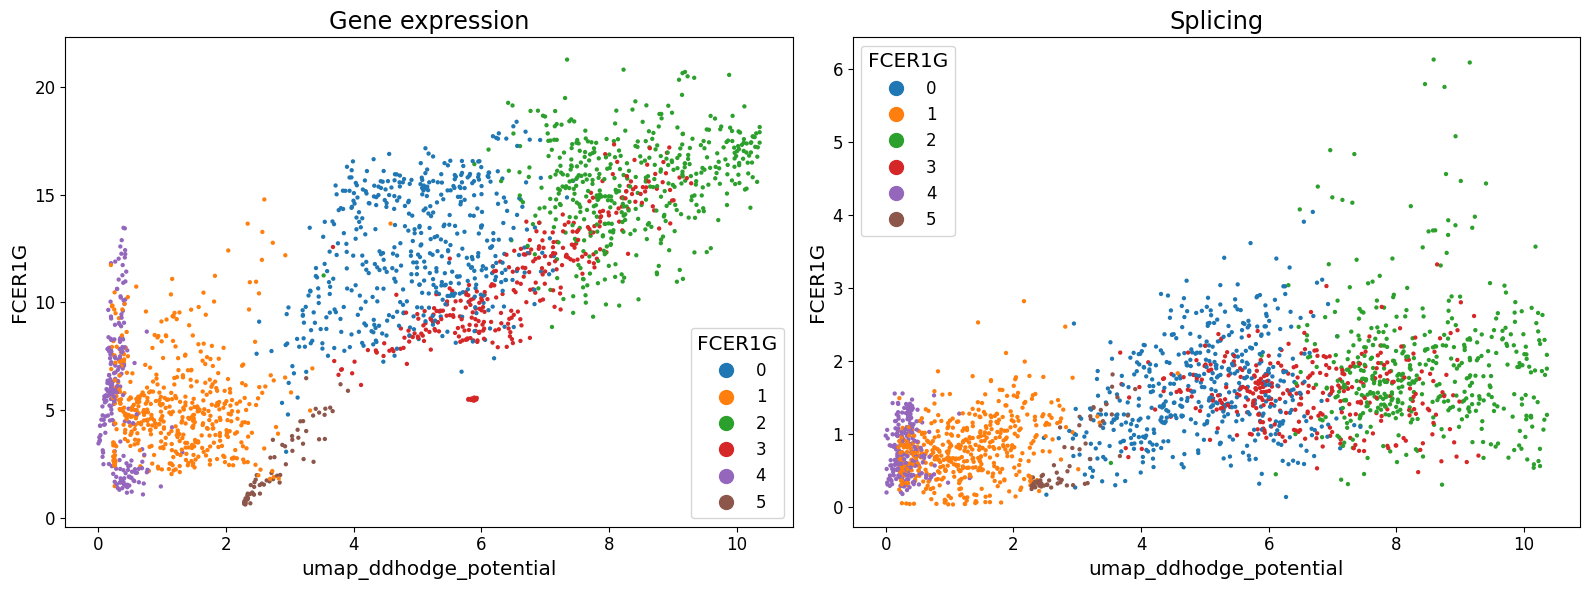

In [5]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


magic_op = magic.MAGIC()
emt_magic = magic_op.fit_transform(emt_data, genes=['MRC1','CD68','CYBB','MS4A4A', 'FCER1G','umap_ddhodge_potential'])
emt_magic2 = magic_op.fit_transform(emt_data2, genes=['MRC1','CD68','CYBB','MS4A4A', 'FCER1G','umap_ddhodge_potential'])

emt_magic['umap_ddhodge_potential'] = adata.obs['umap_ddhodge_potential']
emt_magic['cluster'] = adata.obs.leiden
emt_magic['Status'] = adata.obs.Status

emt_magic2['umap_ddhodge_potential'] = adata.obs['umap_ddhodge_potential']
emt_magic2['cluster'] = adata.obs.leiden
emt_magic2['Status'] = adata.obs.Status
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

scprep.plot.scatter(x=emt_magic['umap_ddhodge_potential'], y=emt_magic['FCER1G'], c=emt_magic['cluster'],  ax=ax1,
                    xlabel='umap_ddhodge_potential', ylabel='FCER1G', legend_title="FCER1G", title='Gene expression')



scprep.plot.scatter(x=emt_magic2['umap_ddhodge_potential'], y=emt_magic2['FCER1G'], c=emt_magic2['cluster'] , ax=ax2,
                    xlabel='umap_ddhodge_potential', ylabel='FCER1G', legend_title="FCER1G", title='Splicing')

plt.tight_layout()



100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


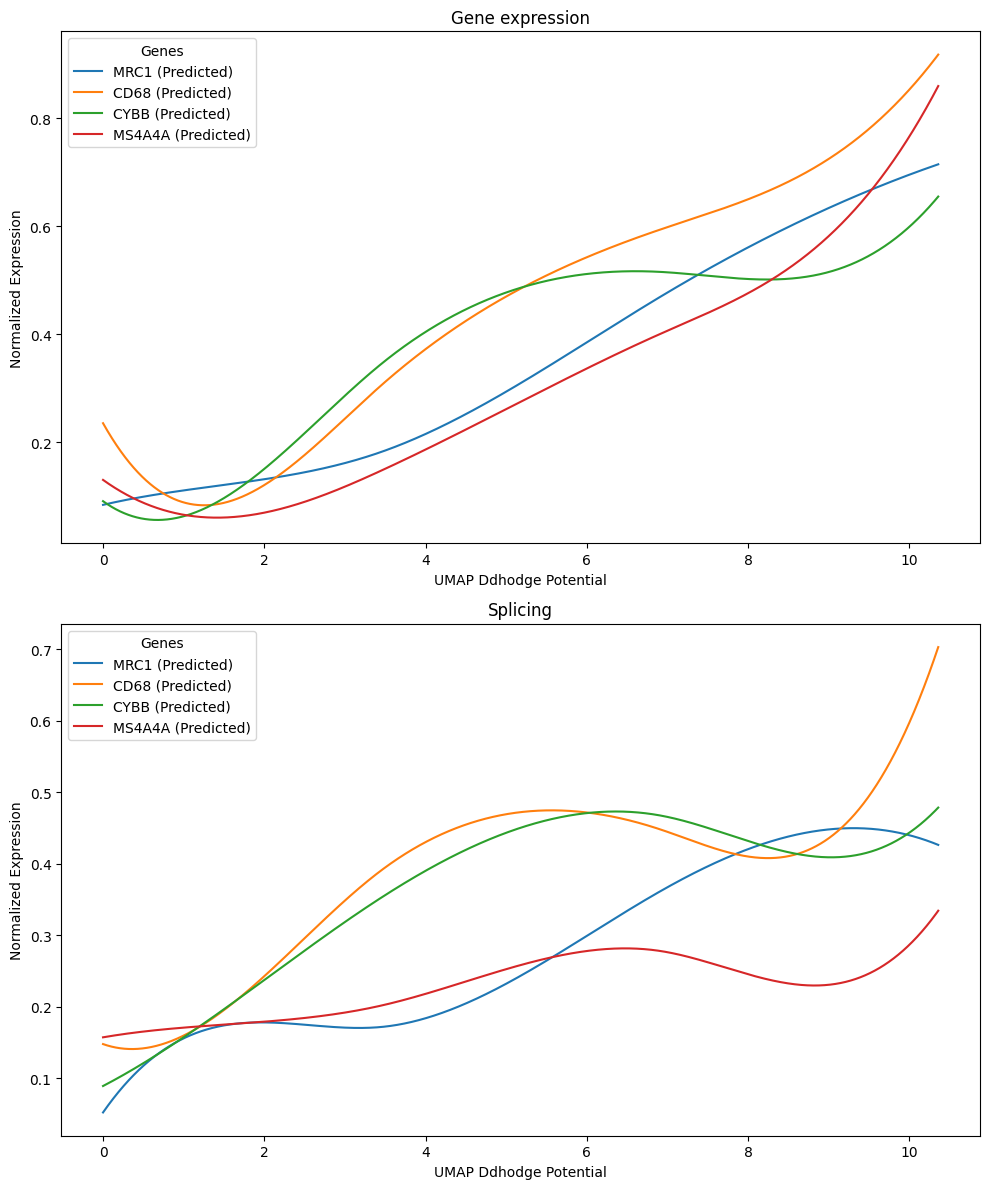

In [6]:
from pygam import LinearGAM
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# List of genes to plot
genes = ['MRC1', 'CD68', 'CYBB', 'MS4A4A']

# Function to fit GAM and generate smoothed data
def gam_fit_and_predict(x, y):
    # Reshape x to (n_samples, 1)
    x = x.reshape(-1, 1)
    
    # Fit the GAM model
    gam = LinearGAM(n_splines= 6, max_iter=10000).gridsearch(x, y)
    
    # Generate X grid for predictions
    XX = gam.generate_X_grid(term=0, n=10000)
    
    # Get the predicted values
    y_pred = gam.predict(XX)
    
    return XX, y_pred

# Normalize y values using MinMaxScaler
def normalize_data(y):
    scaler = MinMaxScaler()
    y_normalized = scaler.fit_transform(y.reshape(-1, 1))  # Reshape for scaler
    return y_normalized.flatten()

# Generate a color palette for the genes
palette = sns.color_palette("tab10", len(genes))  # A distinct color palette for each gene

# Plotting data before and after MAGIC
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Before MAGIC
for i, gene in enumerate(genes):
    x = emt_magic['umap_ddhodge_potential'].values
    y = emt_magic[gene].values
    y_normalized = normalize_data(y)  # Normalize the y values
    XX, y_pred = gam_fit_and_predict(x, y_normalized)
    
    # Plot the predictions with gene-specific colors (without confidence intervals)
    ax1.plot(XX, y_pred, label=f'{gene} (Predicted)', color=palette[i])

ax1.set_title('Gene expression')
ax1.set_xlabel('UMAP Ddhodge Potential')
ax1.set_ylabel('Normalized Expression')
ax1.legend(title="Genes")

# After MAGIC
for i, gene in enumerate(genes):
    x = emt_magic2['umap_ddhodge_potential'].values
    y = emt_magic2[gene].values
    y_normalized = normalize_data(y)  # Normalize the y values
    XX, y_pred = gam_fit_and_predict(x, y_normalized)
    
    # Plot the predictions with gene-specific colors (without confidence intervals)
    ax2.plot(XX, y_pred, label=f'{gene} (Predicted)', color=palette[i])

ax2.set_title('Splicing')
ax2.set_xlabel('UMAP Ddhodge Potential')
ax2.set_ylabel('Normalized Expression')
ax2.legend(title="Genes")

# Save the plot as a PDF file
plt.tight_layout()

# Show the plot
plt.show()
